Scrap Work

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from parallel_pandas import ParallelPandas

In [2]:
ParallelPandas.initialize(n_cpu=16, split_factor=4, disable_pr_bar=True)

Part 1: Building Preferences

In [296]:
def mdf_np(n, k = 3):
    x = pd.DataFrame(np.random.randint(0, n, (int(n*1.2),k)))
    x = x[~(x.apply(lambda row: len(row) != len(set(row)), axis=1))]
    if len(x)<n:
        return "Oops"
    else:
        x = x.iloc[:n].reset_index(drop=True)
        x['student_id'] = x.index
        x['applications'] = 0
        x['N'] = 0
        x['k'] = 0
        x['matched'] = False
    return x

In [295]:
def mdf_yp(n, k = 3):
    x = pd.DataFrame(np.random.randint(0, n, (int(n*1.2),k)))
    x = x[~(x.p_apply(lambda row: len(row) != len(set(row)), axis=1))]
    if len(x)<n:
        return "Oops"
    else:
        x = x.iloc[:n].reset_index(drop=True)
        x['student_id'] = x.index
        x['applications'] = 0
        x['N'] = 0
        x['k'] = 0
        x['matched'] = False
    return x

In [5]:
import time

In [6]:
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        end = time.time()
        return end-start
    return wrapper

In [7]:
@timeit
def test_np(n):
    mdf_np(n)

In [8]:
t_np = [test_np(n) for n in [1000, 10000, 100000, 1000000, 10000000]]

In [9]:
@timeit
def test_yp(n):
    mdf_yp(n)

In [10]:
t_yp = [test_yp(n) for n in [1000, 10000, 100000, 1000000, 10000000]]

In [11]:
np.array(t_yp)-np.array(t_np)

array([  2.82958961,   2.68538713,   2.07156491,  -3.40929699,
       -54.69702482])

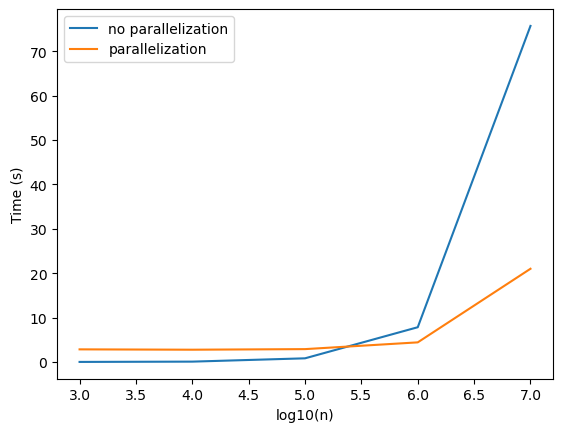

In [12]:
fig, ax = plt.subplots()
ax.plot(np.log10([1000, 10000, 100000, 1000000, 10000000]), t_np, label='np')
ax.plot(np.log10([1000, 10000, 100000, 1000000, 10000000]), t_yp, label='yp')
ax.yaxis.set_label_text('Time (s)')
ax.xaxis.set_label_text('log10(n)')
ax.legend(['no parallelization', 'parallelization'])

Gale Shapley Algorithm

In [13]:
def find_matches(sp):
    '''
    This function takes a dataframe of student preferences and returns a dataframe of matches.
    '''
    sp2 = sp[[0, 'student_id']] ## take the two relevant columns, chosen schools and student IDs
    matches = sp2.sample(frac=1).drop_duplicates(subset=0) ## Will have to reflect the Bayesian nature of this. 
    ## Save the number of applications for each school and then weigh students probabilities by the number of applications. 
    return matches ## Returns our first round of matches. 

In [14]:
def create_mask(sp3, sp):
    '''
    This function takes a dataframe of matches and a dataframe of student preferences and returns a mask of students who have not been assigned to a school.
    '''
    mask = ~(np.logical_or(sp['student_id'].isin(sp3['student_id']), sp['applications'] == 3)) ## creates a mask of all students who have not been assigned to a school. 
    return mask ## The mask gives all values that should be shifted over.

In [15]:
def shift(sp, mask, k = 3):
    '''
    This function takes a dataframe of student preferences, a mask of students who have not been assigned to a school, and the number of schools to apply to. 
    It returns an updated dataframe of student preferences. In this dataframe we have shifted over the values for students who have not been assigned to a school.
    We also update the number of failed applications each student has made.
    '''
    for i in np.arange(k-1):
        sp.loc[mask, i] = sp.loc[mask, i+1] # Shifts over all the values for relevant columns. 
    sp.loc[mask, 'applications'] += 1 ## Updates to new values.
    return sp ## Returns the updated dataframe.

In [16]:
def run_gale_shapley(sp):
    '''Runs the Gale-Shapley Algorithm for a particular dataframe'''
    r_apps = 0
    i=0
    mask = [1]
    while r_apps < 3 and sum(mask) > 0: ## note that there are two ways to end the cycle. 1 all unmatched students have applied to 3 schools. 2. There are no unmatched students.
        matches = find_matches(sp) ## Finds the first round of matches.
        mask = create_mask(matches, sp) ## Creates a mask of students who have not been assigned to a school.
        r_apps = sp.loc[mask, 'applications'].min() < 3 ## Check, if all rejects have already applied to three schools, we terminate. 
        sp = shift(sp, mask) ## Shifts over the values for students who have not been assigned to a school.
        i+=1
    return sp, i

In [17]:
sp = mdf_np(100000)

In [18]:
sp, i = run_gale_shapley(sp)

In [19]:
i

48

Finding ways to speed this up. The costliest part is the isin lookup. 

In [20]:
start = time.time()
matches = find_matches(sp)
end = time.time()
print(end-start)

0.017637252807617188


In [21]:
start = time.time()
create_mask(matches, sp)
end = time.time()
print(end-start)

0.0056514739990234375


Possibly could do something with intersect 1D, which gives the index of schools that get a match? The part that actually takes time is the groupby. 

In [24]:
def find_matches(sp):
    '''
    This function takes a dataframe of student preferences and returns a dataframe of matches.
    '''
    sp2 = sp[[0, 'student_id']] ## take the two relevant columns, chosen schools and student IDs
    matches = sp2.sample(frac=1).drop_duplicates(subset=0) ## Will have to reflect the Bayesian nature of this. 
    ## Save the number of applications for each school and then weigh students probabilities by the number of applications. 
    return matches ## Returns our first round of matches. 


Each match has some weight. Consider someone that is the best out of the "n" offers a school has had. The probability he is better than:

P(x > y| x> x_1, x_2, x_3...)

Where the inequalities should really be preferences. Recall that we assume uniformity. 

In [202]:
x[0].value_counts().reindex(x[0], fill_value=0)

1

In [278]:
def find_p(N, k, matched):
    p =  (N+1)/(k+N)
    x = np.where(matched, p, (1-p)/(k-1))
    x = np.where(k<2, 1, x)
    return x

Faster Code

In [112]:
from functools import partial
randomizers = x.groupby(level = 0).apply(lambda x: partial(np.random.choice, a = x['student_id'], p = x['prob']))
selections = randomizers.apply(lambda f: f())

In [218]:
def find_matches_2(x):
    x = x.set_index(0)
    x = x.sort_index()    # ensure that get_loc below will not return a mask (slow)
    seiv = x['student_id'].values
    sewv = x.prob.values

    def randomizer(t):
        s = x.index.get_loc(t[0])    # either a slice (because of sort) or a scalar
        v = seiv[s]

        if isinstance(s, slice):
            w = sewv[s]
            cw = w.cumsum()    # cumulative weight (i.e. cdf)
            cw /= cw[-1]
            return lambda: v[np.searchsorted(cw, np.random.rand() + 1e-35)]    # inverse cdf
        else:
            return lambda: v    # only one event with this time

    # create a per-minute random function returning id according to weights
    randomizers = x.index.unique().to_frame().apply(randomizer, axis='columns', raw=True)

    # for each observation, find random generator and call it
    selections = pd.DataFrame(randomizers.apply(lambda f: f()))
    selections.columns = ['student_id'] 
    selections.reset_index(inplace=True)
    return selections

This gives a list of all matchings. For the really big ones it might take a little while. 

Ok we now need to build this into the program itself. Then we'll see if we can speed it up further. 

1. Need to have a function that finds k. Ideally we don't want to have to redo the group by in order to find this.
2. Need to be able to update N. I figure we have an N column. After every round we had K to that column. 

In [ ]:
def shift(sp, mask, k = 3):
    '''
    This function takes a dataframe of student preferences, a mask of students who have not been assigned to a school, and the number of schools to apply to. 
    It returns an updated dataframe of student preferences. In this dataframe we have shifted over the values for students who have not been assigned to a school.
    We also update the number of failed applications each student has made.
    '''
    for i in np.arange(k-1):
        sp.loc[mask, i] = sp.loc[mask, i+1] # Shifts over all the values for relevant columns. 
    sp.loc[mask, 'applications'] += 1 ## Updates to new values.
    sp.loc[mask, 'N'] += sp.loc[mask, 'k'] ## Update to show how many students have applied to each school.
    return sp ## Returns the updated dataframe.

In [ ]:
def run_gale_shapley(sp):
    '''Runs the Gale-Shapley Algorithm for a particular dataframe'''
    r_apps = 0
    i=0
    mask = [1]
    while r_apps < 3 and sum(mask) > 0: ## note that there are two ways to end the cycle. 1 all unmatched students have applied to 3 schools. 2. There are no unmatched students.
        matches = find_matches_2(sp) ## Finds the first round of matches.
        mask = create_mask(matches, sp) ## Creates a mask of students who have not been assigned to a school.
        r_apps = sp.loc[mask, 'applications'].min() < 3 ## Check, if all rejects have already applied to three schools, we terminate. 
        sp = shift(sp, mask) ## Shifts over the values for students who have not been assigned to a school.
        i+=1
    return sp, i

In [245]:
def find_k(x):
    x['k'] = x.groupby(0)['student_id'].transform('count')
    return x

### FRESH START

Steps to the loop:

1. Make a dataframe whose columns are first-choice, second-choice, third-choice, studentID, the number of applications a student has made. 


In [247]:
df = mdf_np(100000)
df

,0,1,2,student_id,applications,N
0,55309,19669,81981,0,0,0
1,41231,85525,78889,1,0,0
2,18139,75984,71982,2,0,0
3,5662,92825,82082,3,0,0
4,94708,68486,51481,4,0,0
...,...,...,...,...,...,...
99995,11797,83776,9246,99995,0,0
99996,77645,5394,68466,99996,0,0
99997,11646,19574,96117,99997,0,0
99998,14876,85893,8897,99998,0,0


2. For each find student, we need to find k, the number of people they will be competing against. For their current top school choice 

In [249]:
df = find_k(df)

In [250]:
df.head()

,0,1,2,student_id,applications,N,k
0,55309,19669,81981,0,0,0,2
1,41231,85525,78889,1,0,0,1
2,18139,75984,71982,2,0,0,2
3,5662,92825,82082,3,0,0,1
4,94708,68486,51481,4,0,0,1


In [251]:
## Test
df[df[0] == 55309]

,0,1,2,student_id,applications,N,k
0,55309,19669,81981,0,0,0,2
52224,55309,200,91258,52224,0,0,2


3. Calculate the probability of selection for each student by the school. Initially, this will just be 1/k since we have uniformity.

In [252]:
df['prob'] = find_p(df['N'], df['k'])

In [253]:
df.head()

,0,1,2,student_id,applications,N,k,prob
0,55309,19669,81981,0,0,0,2,0.5
1,41231,85525,78889,1,0,0,1,1.0
2,18139,75984,71982,2,0,0,2,0.5
3,5662,92825,82082,3,0,0,1,1.0
4,94708,68486,51481,4,0,0,1,1.0


4. Find matches while using the weights to determine the likelihood of each match:

In [254]:
matches = find_matches_2(df)

In [255]:
matches.head()

,0,student_id
0,0,93943
1,2,924
2,4,48898
3,5,9854
4,7,37623


5. To this dataframe of matches, we want to tack on the "k" column, i.e. the number of people the person competed against in that period. 

In [261]:
matches['k'] = df.groupby(0)['k'].first().reset_index(drop=True)

In [262]:
matches

,0,student_id,k
0,0,93943,1
1,2,924,1
2,4,48898,2
3,5,9854,1
4,7,37623,2
...,...,...,...
63147,99992,14805,2
63148,99993,75056,2
63149,99996,41776,2
63150,99997,49811,2


6. Create a mask. Returns true for all students who have NOT obtained a match. 

In [257]:
mask = create_mask(matches, df)

7. Add mask column to original dataframe. This highlights who is and isn't in a match

In [263]:
df['matched'] = mask

In [264]:
df.head()

,0,1,2,student_id,applications,N,k,prob,matched
0,55309,19669,81981,0,0,0,2,0.5,True
1,41231,85525,78889,1,0,0,1,1.0,False
2,18139,75984,71982,2,0,0,2,0.5,True
3,5662,92825,82082,3,0,0,1,1.0,False
4,94708,68486,51481,4,0,0,1,1.0,False


8. Shift the columns over appropriately:
Now we should have a new 0 column. Everyone who matched in the past is now going to put forth their second best option. This will also update the number of applications they've made!

In [267]:
df2 = shift(df, mask)

In [269]:
df2

,0,1,2,student_id,applications,N,k,prob,matched
0,81981,81981,81981,0,2,0,2,0.500000,True
1,41231,85525,78889,1,0,0,1,1.000000,False
2,71982,71982,71982,2,2,0,2,0.500000,True
3,5662,92825,82082,3,0,0,1,1.000000,False
4,94708,68486,51481,4,0,0,1,1.000000,False
...,...,...,...,...,...,...,...,...,...
99995,11797,83776,9246,99995,0,0,3,0.333333,False
99996,77645,5394,68466,99996,0,0,1,1.000000,False
99997,96117,96117,96117,99997,2,0,4,0.250000,True
99998,14876,85893,8897,99998,0,0,2,0.500000,False


9. Update N. We now have a new set of choices. For each we need to find the probabilities. For this we need to first update N, and then find the new values of k. 

To update N, we need to find for each school, the number of people who applied in the previous iteration $k_{i-1}$. If the school was not applied to, we need a 0. We then need to add this to N. Two people applying to the same school should have the same N.

In [271]:
df2['N'] += matches.set_index(0)['k'].reindex(df2[0], fill_value=0).reset_index(drop=True)

In [273]:
df2

,0,1,2,student_id,applications,N,k,prob,matched
0,81981,81981,81981,0,2,1,2,0.500000,True
1,41231,85525,78889,1,0,1,1,1.000000,False
2,71982,71982,71982,2,2,0,2,0.500000,True
3,5662,92825,82082,3,0,1,1,1.000000,False
4,94708,68486,51481,4,0,1,1,1.000000,False
...,...,...,...,...,...,...,...,...,...
99995,11797,83776,9246,99995,0,3,3,0.333333,False
99996,77645,5394,68466,99996,0,1,1,1.000000,False
99997,96117,96117,96117,99997,2,0,4,0.250000,True
99998,14876,85893,8897,99998,0,2,2,0.500000,False


In [275]:
find_k(df2)

,0,1,2,student_id,applications,N,k,prob,matched
0,81981,81981,81981,0,2,1,2,0.500000,True
1,41231,85525,78889,1,0,1,1,1.000000,False
2,71982,71982,71982,2,2,0,1,0.500000,True
3,5662,92825,82082,3,0,1,1,1.000000,False
4,94708,68486,51481,4,0,1,1,1.000000,False
...,...,...,...,...,...,...,...,...,...
99995,11797,83776,9246,99995,0,3,1,0.333333,False
99996,77645,5394,68466,99996,0,1,1,1.000000,False
99997,96117,96117,96117,99997,2,0,1,0.250000,True
99998,14876,85893,8897,99998,0,2,2,0.500000,False


In [276]:
df2 = find_k(df2)

In [281]:
df2['prob'] = find_p(df2['N'], df2['k'], ~df2['matched'])

In [282]:
df2

,0,1,2,student_id,applications,N,k,prob,matched
0,81981,81981,81981,0,2,1,2,0.333333,True
1,41231,85525,78889,1,0,1,1,1.000000,False
2,71982,71982,71982,2,2,0,1,1.000000,True
3,5662,92825,82082,3,0,1,1,1.000000,False
4,94708,68486,51481,4,0,1,1,1.000000,False
...,...,...,...,...,...,...,...,...,...
99995,11797,83776,9246,99995,0,3,1,1.000000,False
99996,77645,5394,68466,99996,0,1,1,1.000000,False
99997,96117,96117,96117,99997,2,0,1,1.000000,True
99998,14876,85893,8897,99998,0,2,2,0.750000,False


And now we're back at the starting point. Which is excellent. So now we can turn this into a loop and then we're done. 

In [359]:
def run_gale_shapley(sp):
    '''Runs the Gale-Shapley Algorithm for a particular dataframe'''
    r_apps = 0
    i=0
    mask = [1]
    while r_apps < 3 and sum(mask) > 0: ## note that there are two ways to end the cycle. 1 all unmatched students have applied to 3 schools. 2. There are no unmatched students.
        ## Step 1: Find k
        sp = find_k(sp)
        ## Step 2: Find probabilities
        sp['prob'] = find_p(sp['N'], sp['k'], ~sp['matched']) # Need to check what I should start with here. I don't think this is correct. 
        ## Step 3: Find matches
        matches = find_matches_2(sp).reset_index(drop = True) ## Finds the first round of matches.
        ## Step 5: Add k to matches frame
        matches['k'] = sp.groupby(0)['k'].first().reset_index(drop=True)
        ## Step 6: Create mask
        mask = create_mask(matches, sp) ## Creates a mask of students who have not been assigned to a school.
        sp['matched'] = mask
        ## Step 7: Shift Values Over for unmatched
        sp = shift(sp, mask) 
        ## Step 8: Update N, to reflect total number of matches for each school. 
        sp['N'] += matches.set_index(0)['k'].reindex(sp[0], fill_value=0).reset_index(drop=True)
        ## Step 9: Remove all rejects who have applied to three schools:
        sp = sp[sp['applications'] < 3] # If you've been rejected from three schools, you're out. We also don't want you to stay in the dataset. 
        sp.reset_index(drop=True, inplace=True) # Reset the index
        ## Step 10: update i
        #r_apps = sp.loc[mask, 'applications'].min() < 3 ## Check, if all rejects have already applied to three schools, we terminate. 
        i+=1
    return sp, i

Let's walk through this once. For 2 iterations. And see if it will work. 

In [383]:
sp = mdf_np(100000)

In [384]:
sp = find_k(sp)

In [385]:
sp['prob'] = find_p(sp['N'], sp['k'], ~sp['matched'])

In [386]:
sp

,0,1,2,student_id,applications,N,k,matched,prob
0,94500,33286,3829,0,0,0,2,False,0.500000
1,59316,69719,19860,1,0,0,1,False,1.000000
2,11091,94191,90768,2,0,0,2,False,0.500000
3,14311,50588,58750,3,0,0,1,False,1.000000
4,16145,75777,75334,4,0,0,1,False,1.000000
...,...,...,...,...,...,...,...,...,...
99995,31571,4837,43392,99995,0,0,3,False,0.333333
99996,83206,90136,99403,99996,0,0,1,False,1.000000
99997,74677,63214,82913,99997,0,0,1,False,1.000000
99998,37788,1027,47207,99998,0,0,1,False,1.000000


In [387]:
matches = find_matches(sp).reset_index(drop=True)

In [388]:
matches['k'] = sp.groupby(0)['k'].first().reset_index(drop=True)

In [389]:
matches

,0,student_id,k
0,15948,92307,1
1,46340,76224,1
2,27626,61942,1
3,28654,75268,1
4,16820,98810,2
...,...,...,...
63193,70893,41891,1
63194,95584,33172,1
63195,24163,26914,1
63196,39863,14987,1


In [390]:
mask = create_mask(matches, sp)
sp['matched'] = mask

In [391]:
sp = shift(sp, mask)

In [392]:
matches.set_index(0)['k'].reindex(sp[0], fill_value=0)

0
94500    1
59316    1
94191    1
14311    2
16145    2
        ..
4837     0
83206    2
74677    1
37788    1
85088    1
Name: k, Length: 100000, dtype: int64

In [393]:
sp['N'] += matches.set_index(0)['k'].reindex(sp[0], fill_value=0).reset_index(drop=True)

In [394]:
sp = sp[sp['applications'] < 3]

In [395]:
sp

,0,1,2,student_id,applications,N,k,matched,prob
0,94500,33286,3829,0,0,1,2,False,0.500000
1,59316,69719,19860,1,0,1,1,False,1.000000
2,94191,90768,90768,2,1,1,2,True,0.500000
3,14311,50588,58750,3,0,2,1,False,1.000000
4,16145,75777,75334,4,0,2,1,False,1.000000
...,...,...,...,...,...,...,...,...,...
99995,4837,43392,43392,99995,1,0,3,True,0.333333
99996,83206,90136,99403,99996,0,2,1,False,1.000000
99997,74677,63214,82913,99997,0,1,1,False,1.000000
99998,37788,1027,47207,99998,0,1,1,False,1.000000


In [396]:
sp.reset_index(drop=True, inplace=True) # Reset the index

In [439]:
sp = find_k(sp)
sp['prob'] = find_p(sp['N'], sp['k'], ~sp['matched'])
matches = find_matches(sp).reset_index(drop=True)
matches['k'] = sp.groupby(0)['k'].first().reset_index(drop=True)
mask = create_mask(matches, sp)
sp['matched'] = mask
sp = shift(sp, mask)
sp['N'] += matches.set_index(0)['k'].reindex(sp[0], fill_value=0).reset_index(drop=True) ## Might have to change things here to suppress warnings.
sp = sp[sp['applications'] < 3]
sp.reset_index(drop=True, inplace=True) # Reset the index

In [440]:
sp

,0,1,2,student_id,applications,N,k,matched,prob
0,94500,33286,3829,0,0,26,1,False,1.0
1,69719,19860,19860,1,1,24,1,False,1.0
2,90768,90768,90768,2,2,23,1,False,1.0
3,14311,50588,58750,3,0,27,1,False,1.0
4,16145,75777,75334,4,0,24,1,False,1.0
...,...,...,...,...,...,...,...,...,...
85100,43392,43392,43392,99995,2,21,1,False,1.0
85101,83206,90136,99403,99996,0,24,1,False,1.0
85102,74677,63214,82913,99997,0,24,1,False,1.0
85103,37788,1027,47207,99998,0,23,1,False,1.0


Alternative Matching Method

Reason for this is because previous method makes it difficult to save the salient information for the next round of the game. It will therefore be much easier to be consistent in our university choices across rounds in EADAM. 

1. In the dataframe building phase will also need to draw 3 columns of random uniform numbers. Each will represent how much a school likes a student. Can think of it as rank of student in eyes of the university. Plenty of preferences that never need to be specified.
2. When matching will need to groupby(0), student choices, and then pick the highest ranked student.
3. Decide whether we still really need the "k" column or the "N" column. I think the "N" can be useful in terms of determining whether a school was underdemanded. 

1. Fixing how the dataframe is built. Now we also draw from random uniform distribution to determine the rankings of the school. 

In [602]:
def mdf_np(n, k = 3):
    x = pd.DataFrame(np.random.randint(0, n, (int(n*1.2),k)))
    x = x[~(x.apply(lambda row: len(row) != len(set(row)), axis=1))]
    if len(x)<n:
        return "Oops"
    else:
        x = x.iloc[:n].reset_index(drop=True)
        x['student_id'] = x.index
        x['applications'] = 0
        x['N'] = 0
        x['k'] = 0
        x['matched'] = False
        x[['rank1', 'rank2', 'rank3']] = np.random.uniform(size=(n,3))
        x['underdemanded'] = True
    return x

In [442]:
sp = mdf_np(100000)

In [443]:
sp

,0,1,2,student_id,applications,N,k,matched,rank1,rank2,rank3
0,9626,90777,85100,0,0,0,0,False,0.418494,0.063128,0.022666
1,24137,77641,74142,1,0,0,0,False,0.560411,0.676621,0.165789
2,30245,72719,80429,2,0,0,0,False,0.890433,0.858471,0.420232
3,53743,69698,46120,3,0,0,0,False,0.397810,0.052651,0.312976
4,47640,26857,62691,4,0,0,0,False,0.198086,0.440777,0.518004
...,...,...,...,...,...,...,...,...,...,...,...
99995,58694,17504,92677,99995,0,0,0,False,0.603691,0.249494,0.647500
99996,1584,68498,31603,99996,0,0,0,False,0.744331,0.268231,0.359303
99997,70808,8068,87419,99997,0,0,0,False,0.793871,0.844785,0.453672
99998,12718,74603,47833,99998,0,0,0,False,0.139868,0.018438,0.968170


2. Fixing how the matching gets done. 

In [502]:
def find_matches_3(sp):
    x = sp.sort_values(['rank1'], ascending = False).drop_duplicates(subset = 0)
    return x[[0,'student_id', 'k']] 

In [522]:
def shift(sp, mask, k = 3):
    '''
    This function takes a dataframe of student preferences, a mask of students who have not been assigned to a school, and the number of schools to apply to. 
    It returns an updated dataframe of student preferences. In this dataframe we have shifted over the values for students who have not been assigned to a school.
    We also update the number of failed applications each student has made.
    '''
    for i in np.arange(k-1):
        var1 = 'rank' + str(i+1)
        var2 = 'rank' + str(i+2)
        sp.loc[mask, i] = sp.loc[mask, i+1] # Shifts over all the values for relevant columns.
        sp.loc[mask, var1] = sp.loc[mask, var2]
    sp.loc[mask, 'applications'] += 1 ## Updates to new values.
    #sp.loc[mask, 'N'] += sp.loc[mask, 'k'] ## Update to show how many students have applied to each school.
    return sp ## Returns the updated dataframe.

Let's try step by step

In [516]:
sp = mdf_np(100000)

In [517]:
sp = find_k(sp)
matches = find_matches_3(sp)
#matches['k'] = sp.groupby(0)['k'].first().reset_index(drop=True)



In [519]:
mask = create_mask(matches, sp)

In [520]:
sp.loc[:,'matched'] = mask

In [523]:
sp = shift(sp, mask)

In [526]:
sp

,0,1,2,student_id,applications,N,k,matched,rank1,rank2,rank3
0,36278,2039,26211,0,0,1,1,False,0.864218,0.311489,0.431979
1,98415,73180,69469,1,0,4,4,False,0.878121,0.328789,0.333682
2,50834,44906,38080,2,0,1,1,False,0.262549,0.964757,0.197925
3,75750,2543,2543,3,1,1,3,True,0.443277,0.294898,0.294898
4,64180,10568,60491,4,0,2,2,False,0.940186,0.122234,0.004192
...,...,...,...,...,...,...,...,...,...,...,...
99995,44689,9587,9587,99995,1,1,3,True,0.958699,0.824212,0.824212
99996,85187,80819,80819,99996,1,0,2,True,0.061297,0.437846,0.437846
99997,96285,99341,99341,99997,1,2,2,True,0.139434,0.027746,0.027746
99998,14878,99079,99079,99998,1,1,2,True,0.017462,0.698445,0.698445


In [525]:
sp['N'] += matches.set_index(0)['k'].reindex(sp[0], fill_value=0).reset_index(drop=True)

In [597]:
def run_gale_shapley(sp):
    '''Runs the Gale-Shapley Algorithm for a particular dataframe'''
    r_apps = 0
    i=0
    mask = [1]
    while r_apps < 3 and sum(mask) > 0: ## note that there are two ways to end the cycle. 1 all unmatched students have applied to 3 schools. 2. There are no unmatched students.
        ## Step 1: Find k
        sp = find_k(sp)
        sp['underdemanded'] = np.where(sp['k']>1, False, sp['underdemanded'])

        ## Step 2: Find matches
        matches = find_matches_3(sp) ## finds first round of matches.

        ## Step 3: Create mask and apply to matched column
        mask = create_mask(matches, sp) ## Creates a mask of students who have not been assigned to a school.
        sp.loc[:,'matched'] = mask
        
        ## Step 4: Shift Values Over for unmatched
        sp = shift(sp, mask)

        ## Step 5: Update N, to reflect total number of matches for each school. 
        sp['N'] += matches.set_index(0)['k'].reindex(sp[0], fill_value=0).reset_index(drop=True)

        ## Step 6: Remove all rejects who have applied to three schools:
        sp = sp[sp['applications'] < 3] # If you've been rejected from three schools, you're out. We also don't want you to stay in the dataset. 
        sp.reset_index(drop=True, inplace=True) # Reset the index
        i+=1
    return sp, i

In [2]:
sp = mdf_np(1000000)

NameError: name 'mdf_np' is not defined

In [3]:
sp

NameError: name 'sp' is not defined

In [605]:
run_gale_shapley(sp)

(             0       1       2  student_id  applications   N  k  matched  \
 0       401613  401613  401613           0             2  23  1    False   
 1       767784   51726   51726           2             1  22  1    False   
 2        46639    3966  812978           4             0  19  1    False   
 3       118422  771073  771073           5             1  20  1    False   
 4       609122  609122  609122           6             2  22  1    False   
 ...        ...     ...     ...         ...           ...  .. ..      ...   
 840475  102712  859341  859341      999995             1  20  1    False   
 840476  435094  727732  775631      999996             0  19  1    False   
 840477  534270   40866  784025      999997             0  21  1    False   
 840478  937741  457179  447507      999998             0  22  1    False   
 840479  609227  609227  609227      999999             2  18  1    False   
 
            rank1     rank2     rank3  underdemanded  
 0       0.494542  

Ok, so now underdemanded is any who didn't make this list + all those on this list for which "underdemanded is true". Let's see if this works. Then we go back to original dataframe, remove those observations, and start over. We need to save an instance of each dataframe. I believe from it we can figure out the optimal matching. Let's think about this. 

In [ ]:
pd.concat(sp[sp['underdemanded'] == True][0])